# Feed-Forward Neural Network with Python and Numpy

In this notebook a simple but fully functional feed forward neural network is developed.
Let's start with a rough sketch of the network architecture that we want to achive:

<img src="network-architecture.PNG" alt="Network Architecture" style="width: 700px;" />

If we want an estimation $y_{pred}$ for the input value $x$, just start on the right side of the picture and follow the signal flow to the left.
The symbols along the path have the following meaning:
- $W^{(i)}$ is the weight matrix for the i'th fully connected layer
- $b^{(i)}$ is the bias vector for the i'th layer
- $z^{(i)} := W^{(i)} a^{(i)} + b^{(i)}$ is the activation value for the i'th layer
- $f^{(i)}$ is the activation function of the i'th layer
- $a^{(i)} := f^{(i)}(z^{(i)})$ is the output value of the i'th layer

Now let's begin with importing the libraries which we need later:

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

The weight matrices for each layer are stored in a simple array. Initially all values are randomly normal distributed.

With the matrix dimensions the number of neurons per layer can be controlled.

| Layer | Neurons | Weight matrix | Mapping 
| :---: | :-----: | :-----------: | :-----:
| Input | 2       | $W^{(1)} \in \mathbb{R}^{16 \times 2}$ | $\mathbb{R}^2 \mapsto \mathbb{R}^{16}$
| Hidden| 16      | $W^{(2)} \in \mathbb{R}^{16 \times 16}$| $\mathbb{R}^{16} \mapsto \mathbb{R}^{16}$
| Output| 1       | $W^{(3)} \in \mathbb{R}^{1 \times 16}$ | $\mathbb{R}^{16} \mapsto \mathbb{R}^{1}$

In [22]:
W_layers = [
    np.random.randn(16,2),
    np.random.randn(16,16),
    np.random.randn(1,16)
]

Also the bias vectors for the layers are stored in an array. Their dimension has to fit the dimension of the corresponding weight matrices.

In [23]:
b_layers = []
for i in range(len(W_layers)):
    b_layers.append(np.random.randn(W_layers[i].shape[0],1))

Before we can start declaring the activation functions for the layers, first the activation functions need to be defined.

As a non-linear activation the sigmoid function is widely used:

In [24]:
def sigmoid_activation(x:np.ndarray):
    """ Returns tuple.
        First element: Vector containing output values
        Second element: Vector containing diagonal elements of Jacobian df/dx
    """
    out = 1 / (1 + np.exp(-x))
    dout = out * (1 - out)
    return (out, dout)

The function not only returns the function values but also the first derivative values evaluated at $x$.

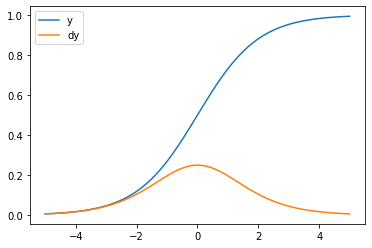

In [25]:
x = np.linspace(-5,5,100)
y,dy = sigmoid_activation(x)
plt.plot(x, y, label="y")
plt.plot(x, dy, label="dy")
plt.legend()
plt.show()

Besides the non-linear activation, a linear activation function is defined too. If we would only stick with the sigmoid and use it also for the output layer, then the output values would be bounded to the interval between 0 ... 1.

In [26]:
def linear_activation(x:np.ndarray):
    """ Returns tuple.
        First element: Vector containing output values
        Second element: Vector containing diagonal elements of Jacobian df/dx
    """
    out = x
    dout = np.ones(x.shape)
    return (out, dout)

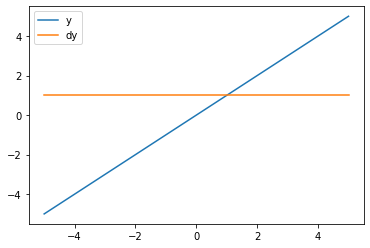

In [27]:
x = np.linspace(-5,5,100)
y,dy = linear_activation(x)
plt.plot(x, y, label="y")
plt.plot(x, dy, label="dy")
plt.legend()
plt.show()

Now the neccessary activation functions are defined and we can create an array which specifies which function we want to use for which layer:

In [28]:
f_layers = [
    sigmoid_activation,
    sigmoid_activation,
    linear_activation
]

The target function is just used as a ground truth that we want to learn. It is obviously non-linear in $x$:

In [29]:
def target_function(x1, x2):
    """ Ground truth that we want to learn.
        R^2 -> R^1
    """
    return 10*np.cos(x1 - x2)**2 + x1 - 2*x2

Visualize target function:

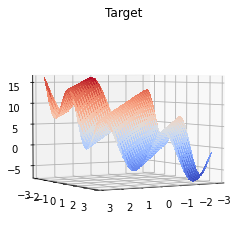

In [30]:
x1_validate = np.arange(-3, 3, 0.25)
x2_validate = np.arange(-3, 3, 0.25)
x1_validate, x2_validate = np.meshgrid(x1_validate, x2_validate)
y_validate = target_function(x1_validate[:], x2_validate[:]).reshape(x1_validate.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1_validate, x2_validate, y_validate, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(3,60)
plt.title("Target")
plt.show()

In the forward pass, layer outputs $a^{(i)}$ and activation $z^{(i)}$ values are calculated from an input sample $x$.

$z^{(1)} = W^{(1)}x + b^{(1)}$

$a^{(1)} = f^{(1)}(z^{(1)})$

$z^{(2)} = W^{(2)}a^{(1)} + b^{(2)}$

$a^{(2)} = f^{(2)}(z^{(2)})$

$z^{(3)} = W^{(3)}a^{(2)} + b^{(3)}$

$a^{(3)} = y_{pred} = f^{(3)}(z^{(3)})$

In [31]:
def forward_pass(x, W_layers, b_layers, f_layers):
    """ Performs forward pass through neural network.
        Returns layer output values (a's) and activation values (z's).
    """
    z_layers = []
    a_layers = []
    a_pre = x.reshape((-1,1))
    for i in range(len(W_layers)):
        z_layers.append(np.hstack([W_layers[i], b_layers[i]]) @ np.vstack([a_pre, 1]))
        a_pre,_ = f_layers[i](z_layers[i])
        a_layers.append(a_pre)
    return (a_layers, z_layers)

In the backward pass, partial derivatives of the cost with respect to the weight matrices and bias vectors are calculated.
Later those derivatives can be used to implement a gradient descent algorithm.

**Derivative of cost with respect to weights:**

$$
\begin{align*}
\frac{\partial C}{\partial W^{(i)}} &= \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial W^{(i)}} \\
                                    &= \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial z^{(i)}} \cdot \frac{\partial z^{(i)}}{\partial W^{(i)}} \\
                                    &= \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial z^{(i)}} \cdot \frac{(\partial W^{(i)}a^{(i-1)} + b^{(i)})}{\partial W^{(i)}} \\
                                    &= \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial z^{(i)}} \cdot (a^{(i-1)})^\text{T} \\
                                    &= \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial f^{(i)}(z^{(i)})}{\partial z^{(i)}} \cdot (a^{(i-1)})^\text{T} \\
                                    &= \delta^{(i)} \cdot (a^{(i-1)})^\text{T} \quad(\text{ with } \delta^{(i)} = \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial f^{(i)}(z^{(i)})}{\partial z^{(i)}} \ )
\end{align*}
$$

**Derivative of cost with respect to intermediate layer output:**

$$
\begin{align*}
\frac{\partial C}{\partial a^{(i)}} &= \frac{\partial C}{\partial a^{(i+1)}} \cdot \frac{\partial a^{(i+1)}}{\partial a^{(i)}} \\
                                    &= \frac{\partial C}{\partial a^{(i+1)}} \cdot \frac{\partial a^{(i+1)}}{\partial z^{(i+1)}} \cdot \frac{\partial z^{(i+1)}}{\partial a^{(i)}} \\
                                    &= \frac{\partial C}{\partial a^{(i+1)}} \cdot \frac{\partial a^{(i+1)}}{\partial z^{(i+1)}} \cdot \frac{\partial (W^{(i+1)}a^{(i)} + b^{(i+1)})}{\partial a^{(i)}} \\
                                    &= \frac{\partial C}{\partial a^{(i+1)}} \cdot \frac{\partial a^{(i+1)}}{\partial z^{(i+1)}} \cdot W^{(i+1)} \\
                                    &= \frac{\partial C}{\partial a^{(i+1)}} \cdot \frac{\partial f^{(i+1)}(z^{(i+1)})}{\partial z^{(i+1)}} \cdot W^{(i+1)} \\
                                    &= \delta^{(i+1)} \cdot W^{(i+1)}
\end{align*}
$$

**Derivative of cost with respect to input $x$:**

$$ \frac{\partial C}{\partial a^{(i)}} =  \delta^{(1)} \cdot W^{(1)} $$

**Derivative of cost with respect to final layer output:**

$$ \frac{\partial C}{\partial y_{pred}} $$

**Derivative of cost with respect to bias:**

$$
\begin{align*}
\frac{\partial C}{\partial b^{(i)}} &= \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial b^{(i)}} \\
                                    &= \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial z^{(i)}} \cdot \frac{\partial z^{(i)}}{\partial b^{(i)}} \\
                                    &= \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial z^{(i)}} \cdot \frac{(\partial W^{(i)}a^{(i-1)} + b^{(i)})}{\partial b^{(i)}} \\
                                    &= \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial a^{(i)}}{\partial z^{(i)}} \\
                                    &= \frac{\partial C}{\partial a^{(i)}} \cdot \frac{\partial f^{(i)}(z^{(i)})}{\partial z^{(i)}} \\
                                    &= \delta^{(i)}
\end{align*}
$$

In [32]:
def backward_pass(x, d_cost, a_layers, z_layers, W_layers, f_layers):
    h_layers = [x, *a_layers] # interpret input as 'layer 0' output
    d_cost_a = d_cost         # derivative of cost w.r.t. current layer output
    d_W_layers = []           # derivative of cost w.r.t. layer weights
    d_b_layers = []           # derivative of cost w.r.t. layer bias
    for i in range(len(W_layers)-1,-1,-1):
        _,d_f = f_layers[i](z_layers[i])
        d = d_cost_a * d_f.transpose()
        d_cost_a = d @ W_layers[i]
        d_W_layers.append(h_layers[i] @ d)
        d_b_layers.append(d)
    d_W_layers.reverse()
    d_b_layers.reverse()
    return (d_W_layers, d_b_layers)

The cost function defines the objective that we want to minimize during the training of the neural network.
Here we use the quadratic error between the predicted value $y$ and the ground truth $y^\star$. The factor $0.5$ is there for convenience, because then the derivative becomes simple:

$$
\begin{align*}
\frac{\partial C}{\partial y} = \frac{\partial \frac{1}{2}(y - y^\star)^2}{\partial y} \\
\frac{\partial C}{\partial y} = y - y^\star
\end{align*}
$$

In [33]:
def cost(y:np.ndarray, y_true:np.ndarray):
    """ Cost function. Returns cost and cost gradient w.r.t. prediction."""
    c = 0.5*np.linalg.norm(y - y_true)**2
    d_c = (y - y_true).transpose()
    return (c, d_c)

With all ingredients defined, it is time to train the neural network. For the training set values of the target function are randomly sampled:

In [34]:
x_train = (1 - np.random.rand(2,200)*2)*3
y_train = target_function(x_train[0,:], x_train[1,:])
x_validate = np.vstack([x1_validate.flatten(), x2_validate.flatten()])
y_validate = y_validate.flatten()

The stochastic gradient descent training procedure goes as follows:
1. Select an training example
2. Perform a forward pass to compute the output
3. Determine error and gradients
4. Use gradients to update weights and bias with a small step-size
5. Repeat steps 1-4 for all training examples

This procedure is repeated for a certain number of iterations (either a fixed number or until the loss has converged). In the code below after each iteration also a validation loss is calculated by using samples which are not in the training set.

In [35]:
learning_rate = 1e-2
n_iterations = 500
loss_train = [0]*n_iterations
loss_validate = [0]*n_iterations
for i in range(n_iterations):
    # Train
    for j in range(x_train.shape[1]):
        x = x_train[:,j].reshape((-1,1))
        y = y_train[j].reshape((1,1))
        a_layers, z_layers = forward_pass(x, W_layers, b_layers, f_layers)
        y_pred = a_layers[-1]
        c,d_c = cost(y_pred, y)
        d_W_layers, d_b_layers = backward_pass(x, d_c, a_layers, z_layers, W_layers, f_layers)
        for k in range(len(W_layers)):
            W_layers[k] = W_layers[k] - (learning_rate*d_W_layers[k]).transpose()
            b_layers[k] = b_layers[k] - (learning_rate*d_b_layers[k]).transpose()
        loss_train[i] = loss_train[i] + c / x_train.shape[1]
    # Validate
    for j in range(x_validate.shape[1]):
        x = x_validate[:,j].reshape((-1,1))
        y = y_validate[j].reshape((1,1))
        a_layers, z_layers = forward_pass(x, W_layers, b_layers, f_layers)
        y_pred = a_layers[-1]
        c,d_c = cost(y_pred, y)
        loss_validate[i] = loss_validate[i] + c / x_validate.shape[1]

Have a look at the loss observed during training:

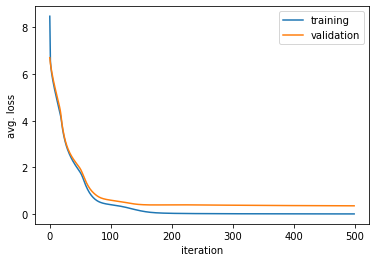

In [36]:
plt.plot(loss_train, label="training")
plt.plot(loss_validate, label="validation")
plt.xlabel("iteration")
plt.ylabel("avg. loss")
plt.legend()
plt.show()

Finally we visualize the predictions of the neural network. Ideally the graph should look similar to the graph plotted when we inspected the target function.

In [37]:
y_pred = []
for i in range(x_validate.shape[1]):
    x = x_validate[:,i].reshape((-1,1))
    a_layers, z_layers = forward_pass(x, W_layers, b_layers, f_layers)
    y_pred.append(a_layers[-1])

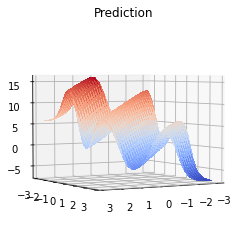

In [38]:
y_pred = np.array(y_pred).reshape(x1_validate.shape)
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(x1_validate, x2_validate, y_pred, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.view_init(3,60)
plt.title("Prediction")
plt.show()